In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os, sys
from ast import literal_eval as make_tuple
from time import time
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

from utils4t import MultipleTimeSeriesCV, format_time

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    # limit GPU Virtual Memory for 5GB
    tf.config.experimental.set_virtual_device_configuration(gpu_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpu_devices), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    # tf.config.experimental.set_memory_growth(gpu_devices[0], True) # can't use when set_virtual_device
else:
    print('Using CPU')

Using GPU
1 Physical GPUs, 1 Logical GPUs


In [5]:
np.random.seed(42)
sns.set_style('whitegrid')
idx = pd.IndexSlice

DATA_STORE = 'data/assets.h5'
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()

checkpoint_path = results_path / 'logs'

data = pd.read_hdf('data/data.h5', 'model_data').dropna().sort_index()
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1874875 entries, ('A', Timestamp('2010-02-22 00:00:00')) to ('ZION', Timestamp('2017-11-29 00:00:00'))
Data columns (total 34 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1874875 non-null  float64
 1   dollar_vol_rank  1874875 non-null  float64
 2   rsi              1874875 non-null  float64
 3   bb_high          1874875 non-null  float64
 4   bb_low           1874875 non-null  float64
 5   NATR             1874875 non-null  float64
 6   ATR              1874875 non-null  float64
 7   PPO              1874875 non-null  float64
 8   MACD             1874875 non-null  float64
 9   sector           1874875 non-null  int32  
 10  r01              1874875 non-null  float64
 11  r05              1874875 non-null  float64
 12  r10              1874875 non-null  float64
 13  r21              1874875 non-null  float64
 14  r42              1874875 non-null  float6

In [6]:
data.sample(10)

,,dollar_vol,dollar_vol_rank,rsi,bb_high,bb_low,NATR,ATR,PPO,MACD,sector,...,r10q_sector,r21q_sector,r42q_sector,r63q_sector,r01_fwd,r05_fwd,r21_fwd,year,month,weekday
symbol,date,,,,,,,,,,,,,,,,,,,,,
TJX,2015-06-19,195.038330,164.0,54.571238,0.007825,0.035598,1.399404,0.082237,-0.684566,-0.462235,1,...,2.0,1.0,3.0,2.0,-0.001351,0.020861,0.028516,2015,6,4
XRX,2014-09-04,203.180740,300.0,55.287666,0.028503,0.038989,1.614002,-0.202887,1.713445,1.214736,0,...,1.0,2.0,4.0,3.0,-0.006608,-0.001468,-0.037317,2014,9,3
THC,2013-03-05,57.358096,379.0,61.165518,0.011663,0.056633,2.917244,0.018773,0.222617,0.649956,4,...,1.0,2.0,4.0,4.0,0.003479,0.084742,0.086730,2013,3,1
LVS,2013-01-31,828.789507,49.0,70.874643,-0.014876,0.089915,2.555645,-0.358527,3.503944,1.193605,1,...,4.0,4.0,4.0,4.0,0.011222,-0.030769,-0.071493,2013,1,3
PSMT,2014-03-13,24.295874,843.0,66.258395,0.012686,0.152416,2.910818,1.386685,4.512733,1.385521,1,...,4.0,4.0,4.0,0.0,-0.011049,0.021263,-0.139090,2014,3,3
TSCO,2010-08-13,15.853539,493.0,50.451819,0.040326,0.022150,2.909609,-1.604488,1.440871,-0.002138,1,...,3.0,2.0,3.0,3.0,0.009920,0.032823,0.101094,2010,8,4
BMY,2011-09-09,336.474191,62.0,53.069181,0.031879,0.054268,2.430537,-0.527995,2.937555,0.185423,4,...,3.0,3.0,4.0,4.0,0.009602,0.046982,0.137307,2011,9,4
NVDA,2015-09-29,222.018537,198.0,60.605399,0.012827,0.083163,2.797360,-0.328174,2.844553,-0.128031,0,...,4.0,4.0,4.0,4.0,0.039224,0.086040,0.209194,2015,9,1
NYT,2016-01-29,16.903428,945.0,55.318298,0.008748,0.075085,2.867645,0.506679,-2.349924,-0.555789,1,...,2.0,2.0,2.0,3.0,-0.019667,-0.055976,-0.037065,2016,1,4


In [7]:
outcomes = data.filter(like='fwd').columns.tolist()

lookahead = 1
outcome= f'r{lookahead:02}_fwd'

X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
y_cv = data.loc[idx[:, :'2017'], outcome]
len(X_cv.index.get_level_values('symbol').unique())

961

In [22]:
outcomes

['r01_fwd', 'r05_fwd', 'r21_fwd']

In [6]:
X_cv.sample(10).sort_values(by='date')

,,dollar_vol,dollar_vol_rank,rsi,bb_high,bb_low,NATR,ATR,PPO,MACD,sector,...,r63dec,r01q_sector,r05q_sector,r10q_sector,r21q_sector,r42q_sector,r63q_sector,year,month,weekday
symbol,date,,,,,,,,,,,,,,,,,,,,,
CAT,2010-12-06,317.532536,33.0,72.077345,0.000372,0.110835,2.055003,-0.411268,2.671365,1.029165,8,...,8.0,1.0,3.0,2.0,4.0,2.0,3.0,2010,12,0
PCH,2012-02-03,7.834364,801.0,42.249840,0.104469,0.032421,2.835267,-0.168764,1.194473,-0.338542,1,...,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2012,2,4
JJSF,2013-10-09,2.917433,974.0,49.782630,0.031151,0.019949,1.859746,-0.442503,1.497053,-0.101681,9,...,2.0,2.0,3.0,2.0,4.0,2.0,1.0,2013,10,2
WSM,2014-09-09,113.360842,218.0,33.054300,0.150131,0.049193,2.068355,0.266452,-1.977028,-1.743736,1,...,2.0,4.0,1.0,0.0,0.0,0.0,0.0,2014,9,1
AVY,2015-03-30,20.033883,659.0,57.416593,0.002273,0.039292,1.434411,-0.550070,-0.348219,-0.362851,11,...,4.0,4.0,2.0,2.0,2.0,1.0,1.0,2015,3,0
CVI,2016-06-22,7.161558,915.0,28.655882,0.193117,0.038722,5.107540,-0.063207,-5.544530,-1.396703,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2016,6,2
F,2017-05-01,355.300639,51.0,48.250462,0.016846,0.044036,1.561405,-1.237363,0.290050,-0.325506,8,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2017,5,0
NBIX,2017-05-19,30.254477,544.0,54.446887,0.034159,0.019146,3.457969,0.799759,0.073731,1.046734,4,...,9.0,0.0,1.0,2.0,2.0,4.0,4.0,2017,5,4
F,2017-06-28,343.941458,68.0,47.573743,0.025213,0.010101,1.499537,-1.398582,0.162880,-0.104191,8,...,2.0,0.0,2.0,1.0,1.0,0.0,0.0,2017,6,2


In [7]:
y_cv.sample(10).sort_values()

symbol  date      
NEM     2011-07-07   -0.003820
NBL     2012-09-11   -0.001171
ONB     2012-06-06   -0.000896
MRVL    2014-09-09    0.000000
KMPR    2015-12-23    0.002632
NFG     2011-03-30    0.007762
PACW    2012-06-29    0.020279
CGNX    2015-11-13    0.022324
NATI    2014-04-29    0.022846
RRC     2016-06-06    0.026199
Name: r01_fwd, dtype: float64

In [8]:
X_cv.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1874875 entries, ('A', Timestamp('2010-02-22 00:00:00')) to ('ZION', Timestamp('2017-11-29 00:00:00'))
Data columns (total 31 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1874875 non-null  float64
 1   dollar_vol_rank  1874875 non-null  float64
 2   rsi              1874875 non-null  float64
 3   bb_high          1874875 non-null  float64
 4   bb_low           1874875 non-null  float64
 5   NATR             1874875 non-null  float64
 6   ATR              1874875 non-null  float64
 7   PPO              1874875 non-null  float64
 8   MACD             1874875 non-null  float64
 9   sector           1874875 non-null  int32  
 10  r01              1874875 non-null  float64
 11  r05              1874875 non-null  float64
 12  r10              1874875 non-null  float64
 13  r21              1874875 non-null  float64
 14  r42              1874875 non-null  float6

In [15]:
# Automate model generation
def make_model(dense_layers, activation, dropout):
    '''Creates a multi-layer perceptron model
    '''
    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        print(i, layer_size)
        if i == 1:
            model.add(Dense(layer_size, input_dim=X_cv.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(layer_size))
            model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='Adam')

    return model

In [16]:
model = make_model((16, 8), 'tanh', [.1])
model.summary()

1 16
2 8
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                512       
                                                                 
 activation_3 (Activation)   (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 activation_4 (Activation)   (None, 8)                 0         
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 657
Trainable params: 657
Non-t

In [10]:
# Cross-validate multiple configurations with TensorFlow
n_splits = 12
train_period_length=21 * 12 * 4
test_period_length=21 * 3
cv = MultipleTimeSeriesCV(n_splits=n_splits, train_period_length=train_period_length,
                          test_period_length=test_period_length, lookahead=lookahead)

In [11]:
# Define CV Parameters
dense_layer_opts = [(16, 8), (32, 16), (32, 32), (64, 32)]
activation_opts = ['tanh']
dropout_opts = [0, .1, .2]
param_grid = list(product(dense_layer_opts, activation_opts, dropout_opts))
np.random.shuffle(param_grid)
len(param_grid)

12

In [12]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    return x_train, y_train, x_val, y_val

ic = []
scaler = StandardScaler()
for params in param_grid:
    dense_layers, activation, dropout = params
    for batch_size in [64, 256]:
        print(f'param info: {dense_layers} | {activation} | {dropout} | {batch_size}')

        checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(dropout) / str(batch_size)
        if not checkpoint_dir.exists():
            checkpoint_dir.mkdir(parents=True, exist_ok=True)

        start = time()
        for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
            # get train & validation data
            x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)

            # scale features
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.transform(x_val)

            # set up dataframes to log results
            preds = y_val.to_frame('actual')
            r = pd.DataFrame(index=y_val.groupby(level='date').size().index)

            # create model based on validation parameters
            model = make_model(dense_layers, activation, dropout)

            # cross-validate for 20 epochs
            for epoch in range(20):
                model.fit(x_train, y_train, batch_size=batch_size, epochs=1, verbose=0, shuffle=True,
                          validation_data=(x_val, y_val), workers=6)
                model.save_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
                preds[epoch] = model.predict(x_val).squeeze()
                r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
                print(format_time(time()-start), f'{fold + 1:02d} | {epoch + 1:02d} | {r[epoch].mean():7.4f} | {r[epoch].median():7.4f}')
            ic.append(r.assign(dense_layers=str(dense_layers), activation=activation, dropout=dropout,
                               batch_size=batch_size, fold=fold))

        t = time()-start
        pd.concat(ic).to_hdf(results_path / 'scores.h5', 'ic_by_day')

param info: (16, 8) | tanh | 0.1 | 64
00:00:32 01 | 01 | -0.0023 |  0.0045
00:01:05 01 | 02 |  0.0083 |  0.0034
00:01:36 01 | 03 |  0.0212 |  0.0458
00:02:07 01 | 04 |  0.0212 |  0.0407
00:02:38 01 | 05 |  0.0100 |  0.0265
00:03:09 01 | 06 |  0.0140 |  0.0146
00:03:39 01 | 07 |  0.0093 |  0.0058
00:04:10 01 | 08 | -0.0024 | -0.0103
00:04:42 01 | 09 |  0.0035 |  0.0017
00:05:14 01 | 10 |  0.0041 | -0.0051
00:05:46 01 | 11 |  0.0040 |  0.0058
00:06:18 01 | 12 |  0.0055 |  0.0011
00:06:49 01 | 13 | -0.0023 | -0.0061
00:07:19 01 | 14 | -0.0009 | -0.0041
00:07:48 01 | 15 | -0.0101 | -0.0224
00:08:16 01 | 16 | -0.0017 | -0.0163
00:08:45 01 | 17 |  0.0090 | -0.0008
00:09:14 01 | 18 | -0.0049 | -0.0076
00:09:43 01 | 19 |  0.0000 | -0.0104
00:10:11 01 | 20 | -0.0046 | -0.0219
00:10:40 02 | 01 |  0.0010 | -0.0056
00:11:08 02 | 02 | -0.0165 | -0.0178
00:11:37 02 | 03 |  0.0245 |  0.0321
00:12:04 02 | 04 | -0.0182 | -0.0105
00:12:32 02 | 05 |  0.0065 |  0.0195
00:13:01 02 | 06 | -0.0074 |  0.0080


In [17]:
# Evaluate predictive performance
params = ['dense_layers', 'dropout', 'batch_size']
ic = pd.read_hdf(results_path / 'scores.h5', 'ic_by_day').drop('activation', axis=1)
ic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18144 entries, 2017-08-30 to 2015-03-02
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   0             18144 non-null  float64
 1   1             18144 non-null  float64
 2   2             18144 non-null  float64
 3   3             18144 non-null  float64
 4   4             18144 non-null  float64
 5   5             18144 non-null  float64
 6   6             18144 non-null  float64
 7   7             18144 non-null  float64
 8   8             18144 non-null  float64
 9   9             18144 non-null  float64
 10  10            18144 non-null  float64
 11  11            18144 non-null  float64
 12  12            18144 non-null  float64
 13  13            18144 non-null  float64
 14  14            18144 non-null  float64
 15  15            18144 non-null  float64
 16  16            18144 non-null  float64
 17  17            18144 non-null  float64
 18  18       

In [19]:
ic.sample(10).sort_values(by=['date', 'dense_layers', 'dropout', 'batch_size', 'fold'])

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,dense_layers,dropout,batch_size,fold
date,,,,,,,,,,,,,,,,,,,,,
2015-01-09,-0.393581,-0.275863,0.066076,0.264810,0.131369,0.296193,0.150136,0.116689,-0.122808,0.035755,...,0.225057,0.299205,-0.006970,0.039841,0.071164,0.080627,"(32, 32)",0.2,64,11
2015-02-27,0.006227,-0.150927,-0.006863,0.017261,-0.137926,0.030384,0.177176,0.127401,0.192749,0.050376,...,-0.015624,-0.083151,-0.074982,-0.034167,0.039482,-0.086455,"(32, 32)",0.2,256,11
2016-01-27,0.039629,0.017442,-0.102254,0.060387,0.073898,0.141775,0.017074,0.077458,0.074455,0.128851,...,0.171471,0.118777,0.172549,0.086380,0.065460,-0.007388,"(32, 32)",0.0,256,7
2016-03-15,0.219253,0.078688,0.207160,0.158813,-0.001880,0.071568,0.158121,0.036735,0.131695,0.076093,...,-0.092821,-0.050120,0.006539,-0.109827,-0.049790,-0.120769,"(32, 16)",0.1,256,6
2016-08-03,-0.023407,0.071858,-0.033862,0.073963,0.062515,0.064195,0.064041,0.052724,0.066285,0.050184,...,0.024603,0.054635,0.070090,0.023805,0.053594,0.058915,"(32, 16)",0.0,64,5
2017-01-30,0.143178,-0.103288,0.319107,0.274637,0.301464,-0.031918,0.189899,0.150050,0.089912,0.033811,...,-0.056780,-0.108612,-0.127154,0.004668,-0.033515,-0.119413,"(64, 32)",0.1,256,3
2017-04-20,-0.010640,-0.168834,0.052610,-0.014188,-0.081048,-0.182437,-0.048229,-0.031020,-0.029950,-0.048761,...,-0.123299,-0.110493,-0.151071,-0.202503,-0.167946,-0.095158,"(16, 8)",0.2,256,2
2017-04-27,0.023056,-0.086213,-0.137775,0.179952,-0.153406,0.169019,-0.070074,-0.080223,0.035939,-0.029794,...,-0.248774,0.119075,-0.196273,0.116168,-0.081624,-0.088839,"(32, 32)",0.2,64,2
2017-05-25,0.027111,-0.015628,0.128114,-0.019290,-0.032147,-0.061568,-0.039574,-0.053571,-0.005801,-0.051649,...,-0.107543,-0.085933,-0.117545,-0.076619,-0.091806,-0.089355,"(64, 32)",0.0,64,2


In [23]:
params

['dense_layers', 'dropout', 'batch_size']

In [14]:
ic.groupby(params).size()

dense_layers  dropout  batch_size
(16, 8)       0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(32, 16)      0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(32, 32)      0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(64, 32)      0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       

In [20]:
ic_long = pd.melt(ic, id_vars=params + ['fold'], var_name='epoch', value_name='ic')
ic_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362880 entries, 0 to 362879
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   dense_layers  362880 non-null  object 
 1   dropout       362880 non-null  float64
 2   batch_size    362880 non-null  int64  
 3   fold          362880 non-null  int64  
 4   epoch         362880 non-null  object 
 5   ic            362880 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 16.6+ MB


In [26]:
pd.concat([ic_long.head(), ic_long.tail()])

,dense_layers,dropout,batch_size,epoch,fold,ic
0,"(16, 8)",0.0,64,0,0,0.005452
1,"(16, 8)",0.0,64,0,1,-0.012513
2,"(16, 8)",0.0,64,0,2,-0.023192
3,"(16, 8)",0.0,64,0,3,-0.029552
4,"(16, 8)",0.0,64,0,4,0.006639
5755,"(64, 32)",0.2,256,19,7,0.023048
5756,"(64, 32)",0.2,256,19,8,0.002248
5757,"(64, 32)",0.2,256,19,9,0.001118
5758,"(64, 32)",0.2,256,19,10,0.030552
5759,"(64, 32)",0.2,256,19,11,0.007263


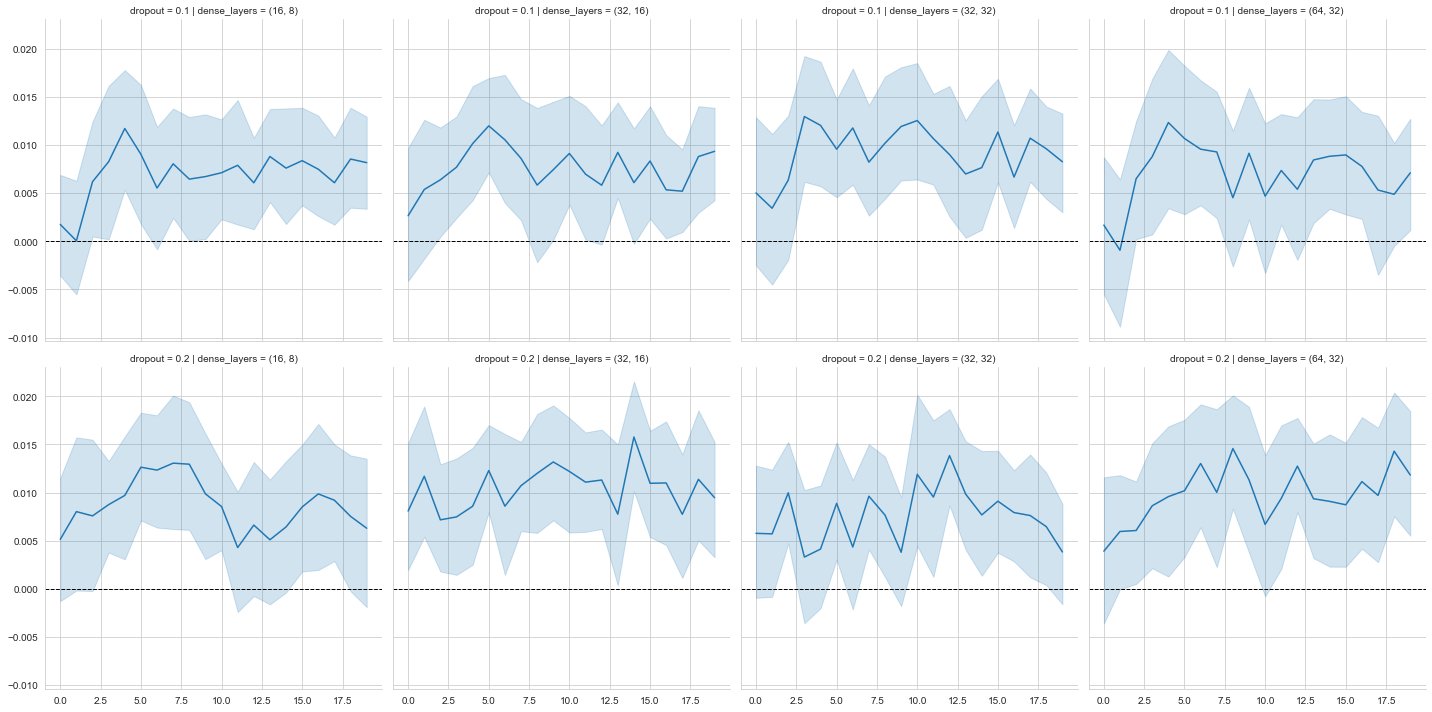

In [31]:
ic_long = ic_long.groupby(params+ ['epoch', 'fold']).ic.mean().to_frame('ic').reset_index()
# visualization the daily IC for different configuration(epoch) to understand how the duration of training affects the predictive accuray. -> IC varies little across models and not particularly systematically across epochs
g = sns.relplot(x='epoch', y='ic', col='dense_layers', row='dropout', data=ic_long[ic_long.dropout>0],
                kind='line')
g.map(plt.axhline, y=0, ls='--', c='k', lw=1)
g.savefig(results_path / 'ic_lineplot', dpi=300);

In [32]:
def run_ols(ic):
    ic.dense_layers = ic.dense_layers.str.replace(', ', '-').str.replace('(', '').str.replace(')', '')
    data = pd.melt(ic, id_vars=params, var_name='epoch', value_name='ic')
    data.epoch = data.epoch.astype(int).astype(str).apply(lambda x: f'{int(x):02.0f}')
    # drop_first=True: reducing the possibility of the multicollinearity, although information may loss
    model_data = pd.get_dummies(data.sort_values(params + ['epoch']), columns=['epoch'] + params, drop_first=True).sort_index(1)
    model_data.columns = [s.split('_')[-1] for s in model_data.columns]
    model = sm.OLS(endog=model_data.ic, exog=sm.add_constant(model_data.drop('ic', axis=1)))
    return model.fit()

model = run_ols(ic.drop('fold', axis=1))
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     ic   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.702
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           1.09e-09
Time:                        23:05:19   Log-Likelihood:             2.3035e+05
No. Observations:              362880   AIC:                        -4.607e+05
Df Residuals:                  362854   BIC:                        -4.604e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.202      0.2

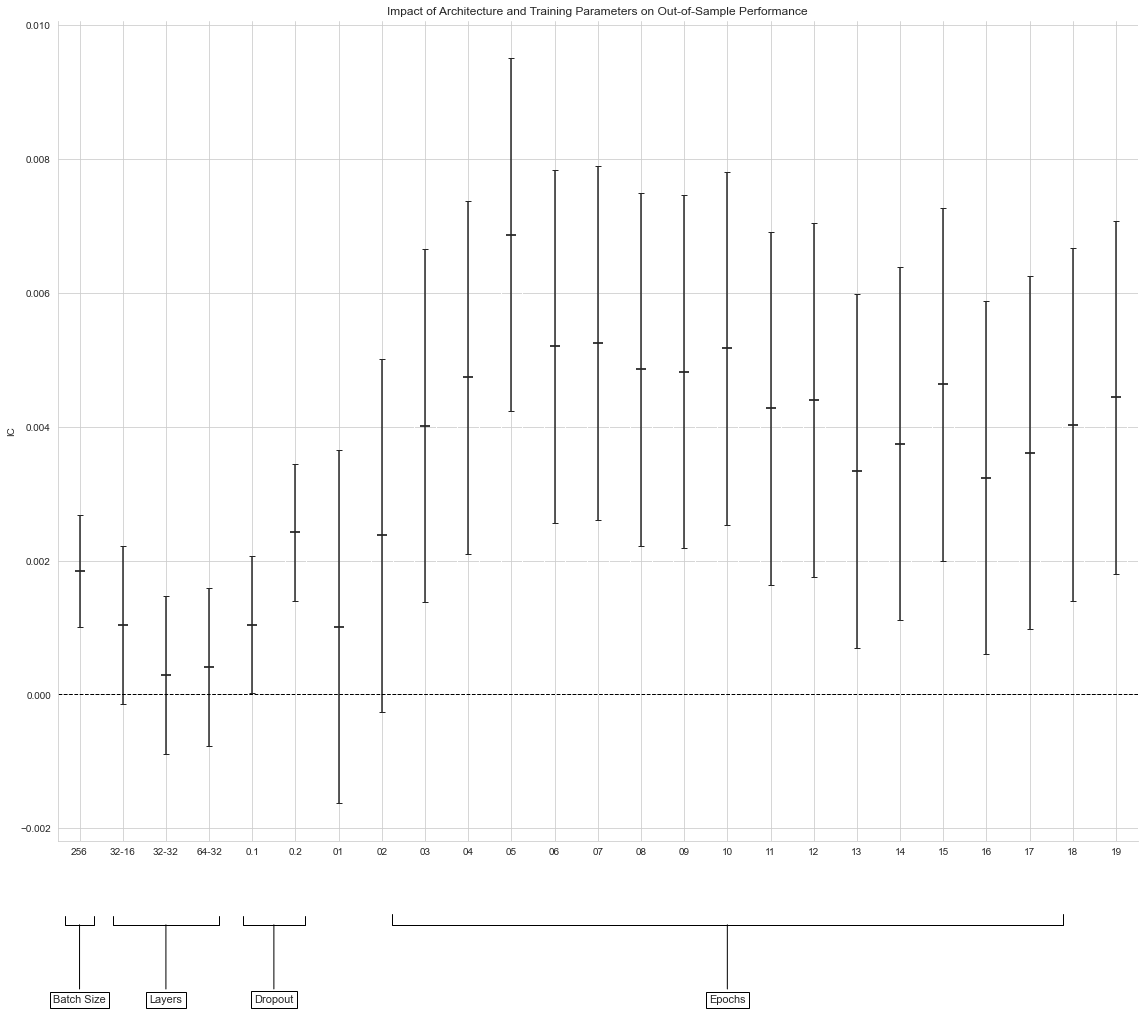

In [33]:
fig, ax = plt.subplots(figsize=(16, 14))

ci = model.conf_int()
errors = ci[1].sub(ci[0]).div(2)

coefs = (model.params.to_frame('coef').assign(error=errors)
         .reset_index().rename(columns={'index': 'variable'}))
coefs = coefs[~coefs['variable'].str.startswith('date') & (coefs.variable != 'const')]

coefs.plot(x='variable', y='coef', kind='bar', ax=ax, color='none', capsize=3,
           yerr='error', legend=False, rot=0, title='Impact of Architecture and Training Parameters on Out-of-Sample Performance')
ax.set_ylabel('IC')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

ax.annotate('Batch Size', xy=(.02, -0.1), xytext=(.02, -0.2), xycoords='axes fraction',
            textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=1.3, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Layers', xy=(.1, -0.1), xytext=(.1, -0.2), xycoords='axes fraction',
            textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=4.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Dropout', xy=(.2, -0.1), xytext=(.2, -0.2), xycoords='axes fraction',
            textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=2.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Epochs', xy=(.62, -0.1), xytext=(.62, -0.2), xycoords='axes fraction',
            textcoords='axes fraction', fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=30.5, lengthB=1.0', lw=1.0, color='black'))

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'ols_coef', dpi=300)

In [37]:
ci

,0,1
const,-0.000823,0.003433
256,0.001015,0.002684
32-16,-0.000146,0.002215
32-32,-0.000890,0.001471
64-32,-0.000763,0.001598
0.1,0.000020,0.002064
0.2,0.001403,0.003447
01,-0.001629,0.003650
02,-0.000263,0.005016
03,0.001375,0.006654


In [20]:
# Make Predictions
def get_best_params(n=5):
    """Get the best parameters across all folds by daily median IC"""
    params = ['dense_layers', 'activation', 'dropout', 'batch_size']
    ic = pd.read_hdf(results_path / 'scores.h5', 'ic_by_day').drop('fold', axis=1)
    dates = sorted(ic.index.unique())
    train_period = 24 * 21
    train_dates = dates[:train_period]
    ic = ic.loc[train_dates]
    return (ic.groupby(params).median().stack().to_frame('ic').reset_index()
            .rename(columns={'level_4': 'epoch'}).nlargest(n=n, columns='ic').drop('ic', axis=1)
            .to_dict('records'))

def generate_predictions(dense_layers, activation, dropout, batch_size, epoch):
    data = pd.read_hdf('data/data.h5', 'model_data').dropna().sort_index()
    outcomes = data.filter(like='fwd').columns.tolist()
    X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
    input_dim = X_cv.shape[1]
    y_cv = data.loc[idx[:, :'2017'], 'r01_fwd']

    scaler = StandardScaler()
    predictions = []

    do = '0' if str(dropout) == '0.0' else str(dropout)
    checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(do) / str(batch_size)

    for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
        x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
        x_val = scaler.fit(x_train).transform(x_val)
        model = make_model(make_tuple(dense_layers), activation, dropout)
        status = model.load_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(x_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)
best_params = get_best_params()
predictions = []
for i, params in enumerate(best_params):
    predictions.append(generate_predictions(**params).to_frame(i))

predictions = pd.concat(predictions, axis=1)
print(predictions.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 723539 entries, ('A', Timestamp('2017-08-30 00:00:00')) to ('ZION', Timestamp('2015-03-02 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       723539 non-null  float32
 1   1       723539 non-null  float32
 2   2       723539 non-null  float32
 3   3       723539 non-null  float32
 4   4       723539 non-null  float32
dtypes: float32(5)
memory usage: 16.6+ MB
None


In [21]:
# save predictions
predictions.to_hdf(results_path / 'test_preds.h5', 'predictions')